In [0]:
%sh pip install kaggle
%sh
export KAGGLE_USERNAME=kn0wh3re
export KAGGLE_KEY=[YOUR_KAGGLE_KEY]
kaggle datasets download -d yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018

In [0]:
!mkdir airline_dataset
!unzip airline-delay-and-cancellation-data-2009-2018.zip -d airline_dataset

In [0]:
dbutils.fs.ls("file:/databricks/driver/airline_dataset/")

In [0]:
dbutils.fs.mkdirs("dbfs:/FileStore/data/airline_dataset")

dbutils.fs.cp("file:/databricks/driver/airline_dataset/", "dbfs:/FileStore/data/airline_dataset", recurse = True)

## Data Download checkpoint

In [0]:
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, ArrayType  

dataset_path = 'dbfs:/FileStore/data/airline_dataset/'

file_count = len(dbutils.fs.ls(dataset_path))
assert file_count == 10, f"Data not found, or filecount was not correct ({file_count}). You may want to check the path or run the notebook from start again"

In [0]:
files = [fileinfo.path for fileinfo in dbutils.fs.ls(dataset_path)]
files

Out[2]: ['dbfs:/FileStore/data/airline_dataset/2009.csv',
 'dbfs:/FileStore/data/airline_dataset/2010.csv',
 'dbfs:/FileStore/data/airline_dataset/2011.csv',
 'dbfs:/FileStore/data/airline_dataset/2012.csv',
 'dbfs:/FileStore/data/airline_dataset/2013.csv',
 'dbfs:/FileStore/data/airline_dataset/2014.csv',
 'dbfs:/FileStore/data/airline_dataset/2015.csv',
 'dbfs:/FileStore/data/airline_dataset/2016.csv',
 'dbfs:/FileStore/data/airline_dataset/2017.csv',
 'dbfs:/FileStore/data/airline_dataset/2018.csv']

In [0]:
# # Build map of spark dataframes by reading json partition chunk files
# dataframes_map = map(lambda r: spark.read.csv(r, header=True), [f"{file}" for file in files])
# # reduce the dataframes into single dataframe by performing union over the mapped frames.
# df = reduce(lambda df1, df2: df1.unionByName(df2, allowMissingColumns=True), dataframes_map)
df = spark.read.csv(files[0], header=True)
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: strin

In [0]:
# df = spark.read.csv(files[0], header=True)
df = df.drop('Unnamed: 27')
df.show()

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-01-01|        XE|             1

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.mllib.linalg import Vectors
from pyspark.ml.param import Param, Params
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

In [0]:
df = df.dropna(how="all").na.fill(value=0, subset=['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'])
df.show(2)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-01-01|        XE|             1

In [0]:
cancelled_flights = df.filter("CANCELLED == 1")
frame = cancelled_flights.groupBy("OP_CARRIER", "CANCELLATION_CODE").count().toPandas()

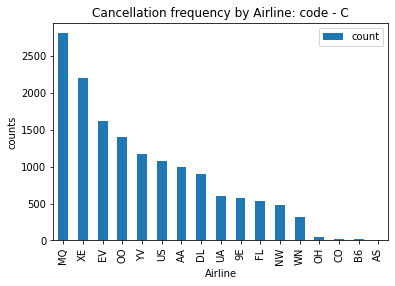

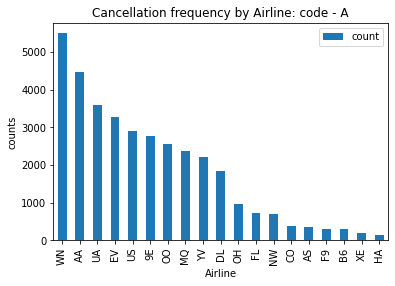

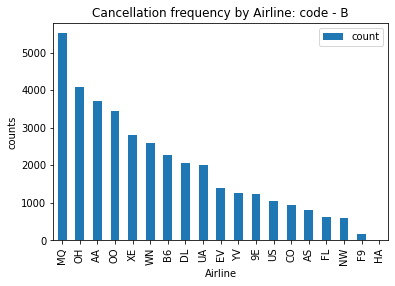

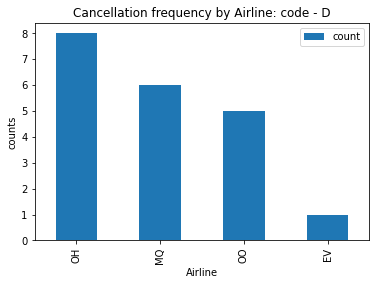

In [0]:
cancellation_codes = frame["CANCELLATION_CODE"].unique()
for cancellation_code in cancellation_codes:
    sorted_frame = frame[frame["CANCELLATION_CODE"] == cancellation_code].sort_values(by=["count"], ascending=False)
    sorted_frame.plot(x="OP_CARRIER", y="count", kind="bar", ylabel="counts", xlabel="Airline", title=f"Cancellation frequency by Airline: code - {cancellation_code}")

In [0]:
import pyspark.sql.functions as F

# df = df.withColumn("FL_DATE", F.col("FL_DATE").cast("timestamp"))

string_columns = ['FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST']
numeric_columns = ['DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME']

for num_column in numeric_columns:
    df = df.withColumn(num_column, F.col(num_column).cast('float'))
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: float (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: float (nullable = true)
 |-- DEP_TIME: float (nullable = true)
 |-- DEP_DELAY: float (nullable = true)
 |-- TAXI_OUT: float (nullable = true)
 |-- WHEELS_OFF: float (nullable = true)
 |-- WHEELS_ON: float (nullable = true)
 |-- TAXI_IN: float (nullable = true)
 |-- CRS_ARR_TIME: float (nullable = true)
 |-- ARR_TIME: float (nullable = true)
 |-- ARR_DELAY: float (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: float (nullable = true)
 |-- CRS_ELAPSED_TIME: float (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: float (nullable = true)
 |-- AIR_TIME: float (nullable = true)
 |-- DISTANCE: float (nullable = true)
 |-- CARRIER_DELAY: float (nullable = true)
 |-- WEATHER_DELAY: float (nullable = true

In [0]:
df = df.na.fill(value=0, subset=numeric_columns)
df = df.drop("CANCELLATION_CODE")
df.count()

Out[10]: 6429338

In [0]:
df = df.na.drop("any")

In [0]:
stages = [] # stages in our Pipeline

for categoricalCol in string_columns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index", handleInvalid="skip")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]


# Convert label into label indices using the StringIndexer
label_stringIdx =  StringIndexer(inputCol="CANCELLED", outputCol="label")
stages += [label_stringIdx]

assemblerInputs = [c + "classVec" for c in string_columns] + numeric_columns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features', handleInvalid="skip")
stages += [assembler]

In [0]:
# Create a Pipeline.
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(df)
PreparedData = pipelineModel.transform(df)

In [0]:
PreparedData.show(1, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 FL_DATE             | 2009-01-01                                                                                                                                                                                    
 OP_CARRIER          | XE                                                                                                                                                                                            
 OP_CARRIER_FL_NUM   | 1204.0                                                                                                                                                                                        
 ORIGIN              | DCA                                                                                                                      

In [0]:
stages

Out[15]: [StringIndexer_dcd7368eee1f,
 OneHotEncoder_bbf717d03323,
 StringIndexer_d19824f4dfdf,
 OneHotEncoder_f3fbdbd59c25,
 StringIndexer_dc4e44dcdf51,
 OneHotEncoder_0266bebaabd1,
 StringIndexer_b43998d1e198,
 OneHotEncoder_efd7a828da9c,
 StringIndexer_28032840e826,
 VectorAssembler_ef715c089f4e]

In [0]:
(trainingData, testData) = PreparedData.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

4500654
1928684


In [0]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.1)
lrModel = lr.fit(trainingData)
lrPredictions = lrModel.transform(testData)

dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtcModel = dtc.fit(trainingData)
dtcPredictions = dtcModel.transform(testData)

rfc = RandomForestClassifier(labelCol="label", featuresCol="features")
rfcModel = rfc.fit(trainingData)
rfcPredictions = rfcModel.transform(testData)

gbc = GBTClassifier(labelCol="label", featuresCol="features")
gbcModel = gbc.fit(trainingData)
gbcPredictions = gbcModel.transform(testData)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator()
accuracies = [
    evaluator.evaluate(lrPredictions),
	evaluator.evaluate(dtcPredictions),
	evaluator.evaluate(rfcPredictions), 
	evaluator.evaluate(gbcPredictions)
]

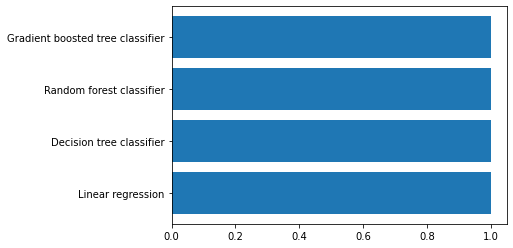

In [0]:
ids = [0, 1, 2, 3]
accuracy_labels = ['Linear regression', 'Decision tree classifier', 'Random forest classifier', 'Gradient boosted tree classifier']

plt.barh(accuracy_labels, accuracies)
plt.show()